In [729]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

# need exoplanet version 0.3.3 for the gp submodule. 
#Should upgrade specgp to use celerite2 eventually. 
import exoplanet as xo
import specgp as sgp
from specgp.distributions import MvUniform

In [730]:
data = np.loadtxt('K22b.dat')
t = data[:, -1]
data = data[:, :-1]

#b, g, r = [band/np.mean(band) for band in data.T]

estimated white noise: [0.00023389 0.00021368 0.00022625]


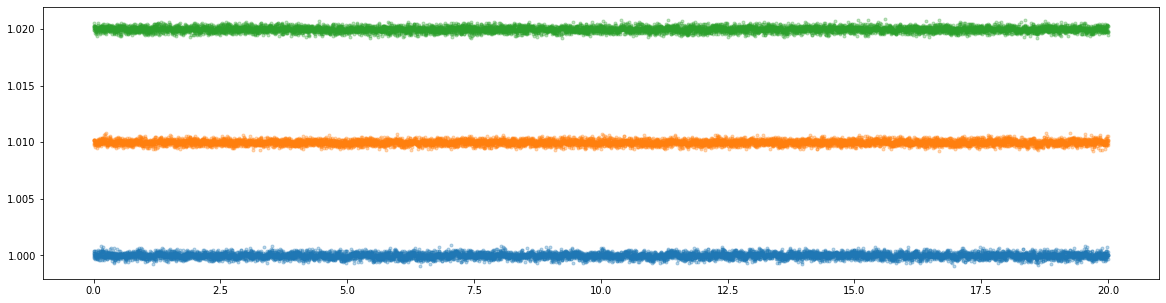

In [731]:
pl.figure(figsize=(20, 5))
for i, f in enumerate(data.T):
    pl.plot(t/(60*60), f/np.mean(f) + 0.01*i, '.', alpha=0.3)
wn_est = np.std(data/np.mean(data, axis=0), axis=0)
print("estimated white noise: {0}".format(wn_est))

In [732]:
obs = np.reshape(np.array([f/np.mean(f) for f in data.T]).T, (np.shape(data)[1]*len(t)))

def getmodel(holds={}, mu={}, sig={}, transform=False, nterms=1):
    
    params = ['logS0', 'logw', 'alpha', 
             'logsig', 'mean', 'u', 'logrp', 't0p', 't0m']
    for p in params:
        if p not in holds:
            holds[p] = None
        if p not in mu:
            mu[p] = None
        if p not in sig:
            sig[p] = None
    
    with pm.Model() as model:
        logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"], observed=holds['logS0'])
        logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"], observed=holds['logw'])
        
        if np.shape(data)[1] > 1:
            alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(data)[1]-1, observed=holds['alpha'])
        logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(data)[1], observed=holds['logsig'])
        mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(data)[1], observed=holds['mean'])
        u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
                                        testval=[0.5, 0.5], observed=holds['u'])
        
        if transform:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                               observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                             observed=holds['t0p'])
        else:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
                           transform=None, observed=holds['logrp'])
            t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
                         transform=None, observed=holds['t0p'])
        
        orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
        lcp = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
        mean = mean[:, None] + lcp.T[0]
    
        term = xo.gp.terms.SHOTerm(
                log_S0 = logS0,
                log_w0 = logw,
                log_Q = -np.log(np.sqrt(2))
            )
        
        if np.shape(data)[1] > 1:
            a = tt.exp(tt.concatenate([[0.0], alpha]))
            kernel = sgp.terms.KronTerm(term, alpha=a)
        else:
            kernel = term
        
        yerr = tt.exp(2 * logsig)
        yerr = yerr[:, None] * tt.ones(len(t))
        
        if np.shape(data)[1] > 1:
            gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
        else:
            gp = xo.gp.GP(kernel, t, yerr[0], J=2, mean=mean)
        marg = gp.marginal("gp", observed = obs.T)
    return model

In [733]:
nb = np.shape(data)[1]
mu = {'logS0':np.log(8e-11), 'logw':np.log(866), 'alpha':np.zeros(nb-1), 
             'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 'logrp':np.log(0.01), 't0p':5}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
             'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 't0p':2}
m = getmodel(mu=mu, sig=sig)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


In [734]:
with m:
    map_soln = xo.optimize(start=m.test_point, verbose=True)

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [t0p, logrp, u, mean, logsig, alpha, logw, logS0]


message: Desired error not necessarily achieved due to precision loss.
logp: 199590.62245940627 -> 201941.43807569006


In [735]:
np.exp(map_soln['logrp'])

0.0017516979283844387

In [736]:
import copy
holds = copy.deepcopy(map_soln)
holds.pop('logrp')
#astart = holds.pop('alpha')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')

start = {
    #"alpha": astart,
    "mean": meanstart,
    "logsig": logsigstart,
    "logrp": np.log(0.01)
}

t0grid = np.linspace(3, 7, 50)
ll = np.zeros_like(t0grid)
r = np.zeros_like(t0grid)
for i, t0 in enumerate(t0grid):
    holds['t0p'] = t0
    m = getmodel(holds=holds, mu=mu, sig=sig)
    with m:
        print('\r{0}/{1}'.format(i+1, len(t0grid)), end='')
        newmap_soln = xo.optimize(start=start, verbose=True)
        ll[i] = m.logp(newmap_soln)
        r[i] = np.exp(newmap_soln['logrp'])

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
1/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201617.41360081354 -> 201952.9180876254


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
2/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201615.30508162608 -> 201952.91808762526


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
3/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201617.90458572598 -> 201952.91808762538


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
4/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201615.49840349818 -> 201952.9180876253


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
5/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201611.7272298217 -> 201952.9180876254


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
6/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201608.87066881478 -> 201952.91808762538


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
7/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201610.01567450585 -> 201952.9180876254


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
8/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201614.32610653725 -> 201952.9180876254


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
9/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3

optimizing logp for variables: [logrp, mean, logsig]


message: Optimization terminated successfully.
logp: 201616.27948659842 -> 201952.91808762538


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
10/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201618.37962966505 -> 201952.9180876254


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
11/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201627.0119053954 -> 201952.91808762538


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
12/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201639.05384871823 -> 201952.92123829958


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
13/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201652.9367888939 -> 201953.15501321485


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
14/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201668.81338231082 -> 201953.88793461322


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
15/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201679.93696909165 -> 201954.67610402204


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
16/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201688.62526645468 -> 201955.4813825435


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
17/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201694.47796918682 -> 201956.107538613


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
18/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201699.02926526696 -> 201956.63202121717


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
19/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201706.03013211925 -> 201957.50096806514


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
20/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201708.231416356 -> 201957.78113866382


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
21/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201713.90942016913 -> 201958.6125704708


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
22/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201721.00537919757 -> 201959.70292139714


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
23/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201728.2755612489 -> 201960.92391401762


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
24/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201731.93533241286 -> 201961.60281058526


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
25/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201734.25021545516 -> 201962.0126358252


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
26/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201733.8762655223 -> 201961.93650202316


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
27/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201732.3955373698 -> 201961.64632794552


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
28/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201741.1960147414 -> 201963.37833509356


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
29/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201748.1114912844 -> 201964.830421018


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
30/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201747.1255254191 -> 201964.62002696615


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
31/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201744.08214900046 -> 201963.97955417595


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
32/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201741.63914216092 -> 201963.49135489084


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
33/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201738.1083142352 -> 201962.72424561996


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
34/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201733.84248954747 -> 201961.95432090876


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
35/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201733.19411024934 -> 201961.82292967028


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
36/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201728.04403468588 -> 201960.85156469594


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
37/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201722.74990505486 -> 201959.9533389654


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
38/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201721.66160242743 -> 201959.78817704742


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
39/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201728.32788986186 -> 201960.92826596342


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
40/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201730.3132637436 -> 201961.27554700812


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
41/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201726.9959520064 -> 201960.7032273745


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
42/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201723.51078246362 -> 201960.09657712173


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
43/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201713.6316857287 -> 201958.5314483305


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
44/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201697.08170598478 -> 201956.36958963785


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
45/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201686.6210209862 -> 201955.24186511815


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
46/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201679.29075150282 -> 201954.60033863908


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
47/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201674.61495665266 -> 201954.25030010406


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
48/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201671.37311987294 -> 201954.03389821545


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
49/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201669.0439968411 -> 201953.89096210437


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
50/50['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python

optimizing logp for variables: [logrp, mean, logsig]


message: Desired error not necessarily achieved due to precision loss.
logp: 201661.79838865687 -> 201953.48867368652


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


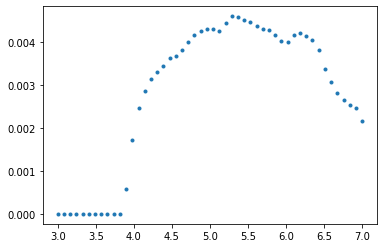

In [737]:
pl.plot(t0grid, r, '.')

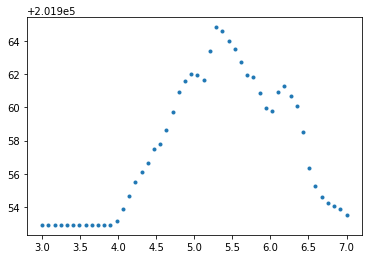

In [738]:
pl.plot(t0grid, ll, '.')

In [755]:
mu = {'logS0':np.log(8e-11), 'logw':np.log(866), 'alpha':np.zeros(nb-1), 
      'logsig':np.log(wn_est), 'mean':np.ones(nb), 'u':[0.5, 0.5], 
      'logrp':np.log(0.0001), 'logrm':np.log(0.005), 't0p':10, 't0m':5}
sig = {'logS0':10, 'logw':10, 'logQ':None, 'alpha':np.ones(nb-1), 
       'logsig':np.ones(nb)*5, 'mean':np.ones(nb)*0.1, 't0p':1, 't0m':1, 'logrm':2}

with pm.Model() as model:
    logS0 = pm.Normal("logS0", mu=mu["logS0"], 
                        sd=sig["logS0"])
    logw = pm.Normal("logw", mu=mu["logw"], 
                       sd=sig["logw"])
    alpha =  pm.MvNormal("alpha", mu=mu["alpha"], 
                          chol=np.diag(sig["alpha"]), shape=np.shape(data)[1]-1)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=np.shape(data)[1])
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=np.shape(data)[1])
    #u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
    #                                    testval=[0.5, 0.5])
    u1 = pm.Uniform("u1", lower=0, upper=1, testval=0.5)
    u2 = pm.Uniform("u2", lower=0, upper=1, testval=0.5)
    u = [u1, u2]
    #logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=mu['logrp'], 
    #                       transform=None)
    #t0p = pm.Uniform("t0p", lower=t[0], upper=t[-1], testval=mu['t0p'], 
    #                     transform=None)
    logrm = pm.Normal("logrm", mu=mu['logrm'], sd=sig['logrm'],
                           transform=None)
    t0m = pm.Normal("t0m", mu=mu['t0m'], sd=sig['t0m'], testval=mu['t0m'], 
                         transform=None)
        
    orbit = xo.orbits.KeplerianOrbit(period=5.0*60*60)
    #lcp = (xo.LimbDarkLightCurve(u)
    #          .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t/(60*60)-t0p, texp=np.mean(np.diff(t))/(60*60)))
    lcm = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrm), t=t/(60*60)-t0m, texp=np.mean(np.diff(t))/(60*60)))
    mean = mean[:, None] + lcm.T[0]
    
    term = xo.gp.terms.SHOTerm(
            log_S0 = logS0,
            log_w0 = logw,
            log_Q = -np.log(np.sqrt(2))
        )
        
    a = tt.exp(tt.concatenate([[0.0], alpha]))
        
    kernel = sgp.terms.KronTerm(term, alpha=a)
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=2, mean=sgp.means.KronMean(mean))
    marg = gp.marginal("gp", observed = obs.T)
        
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=model.test_point,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]
INFO:pymc3:NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6832 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6832 seconds.


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4356219630669084, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


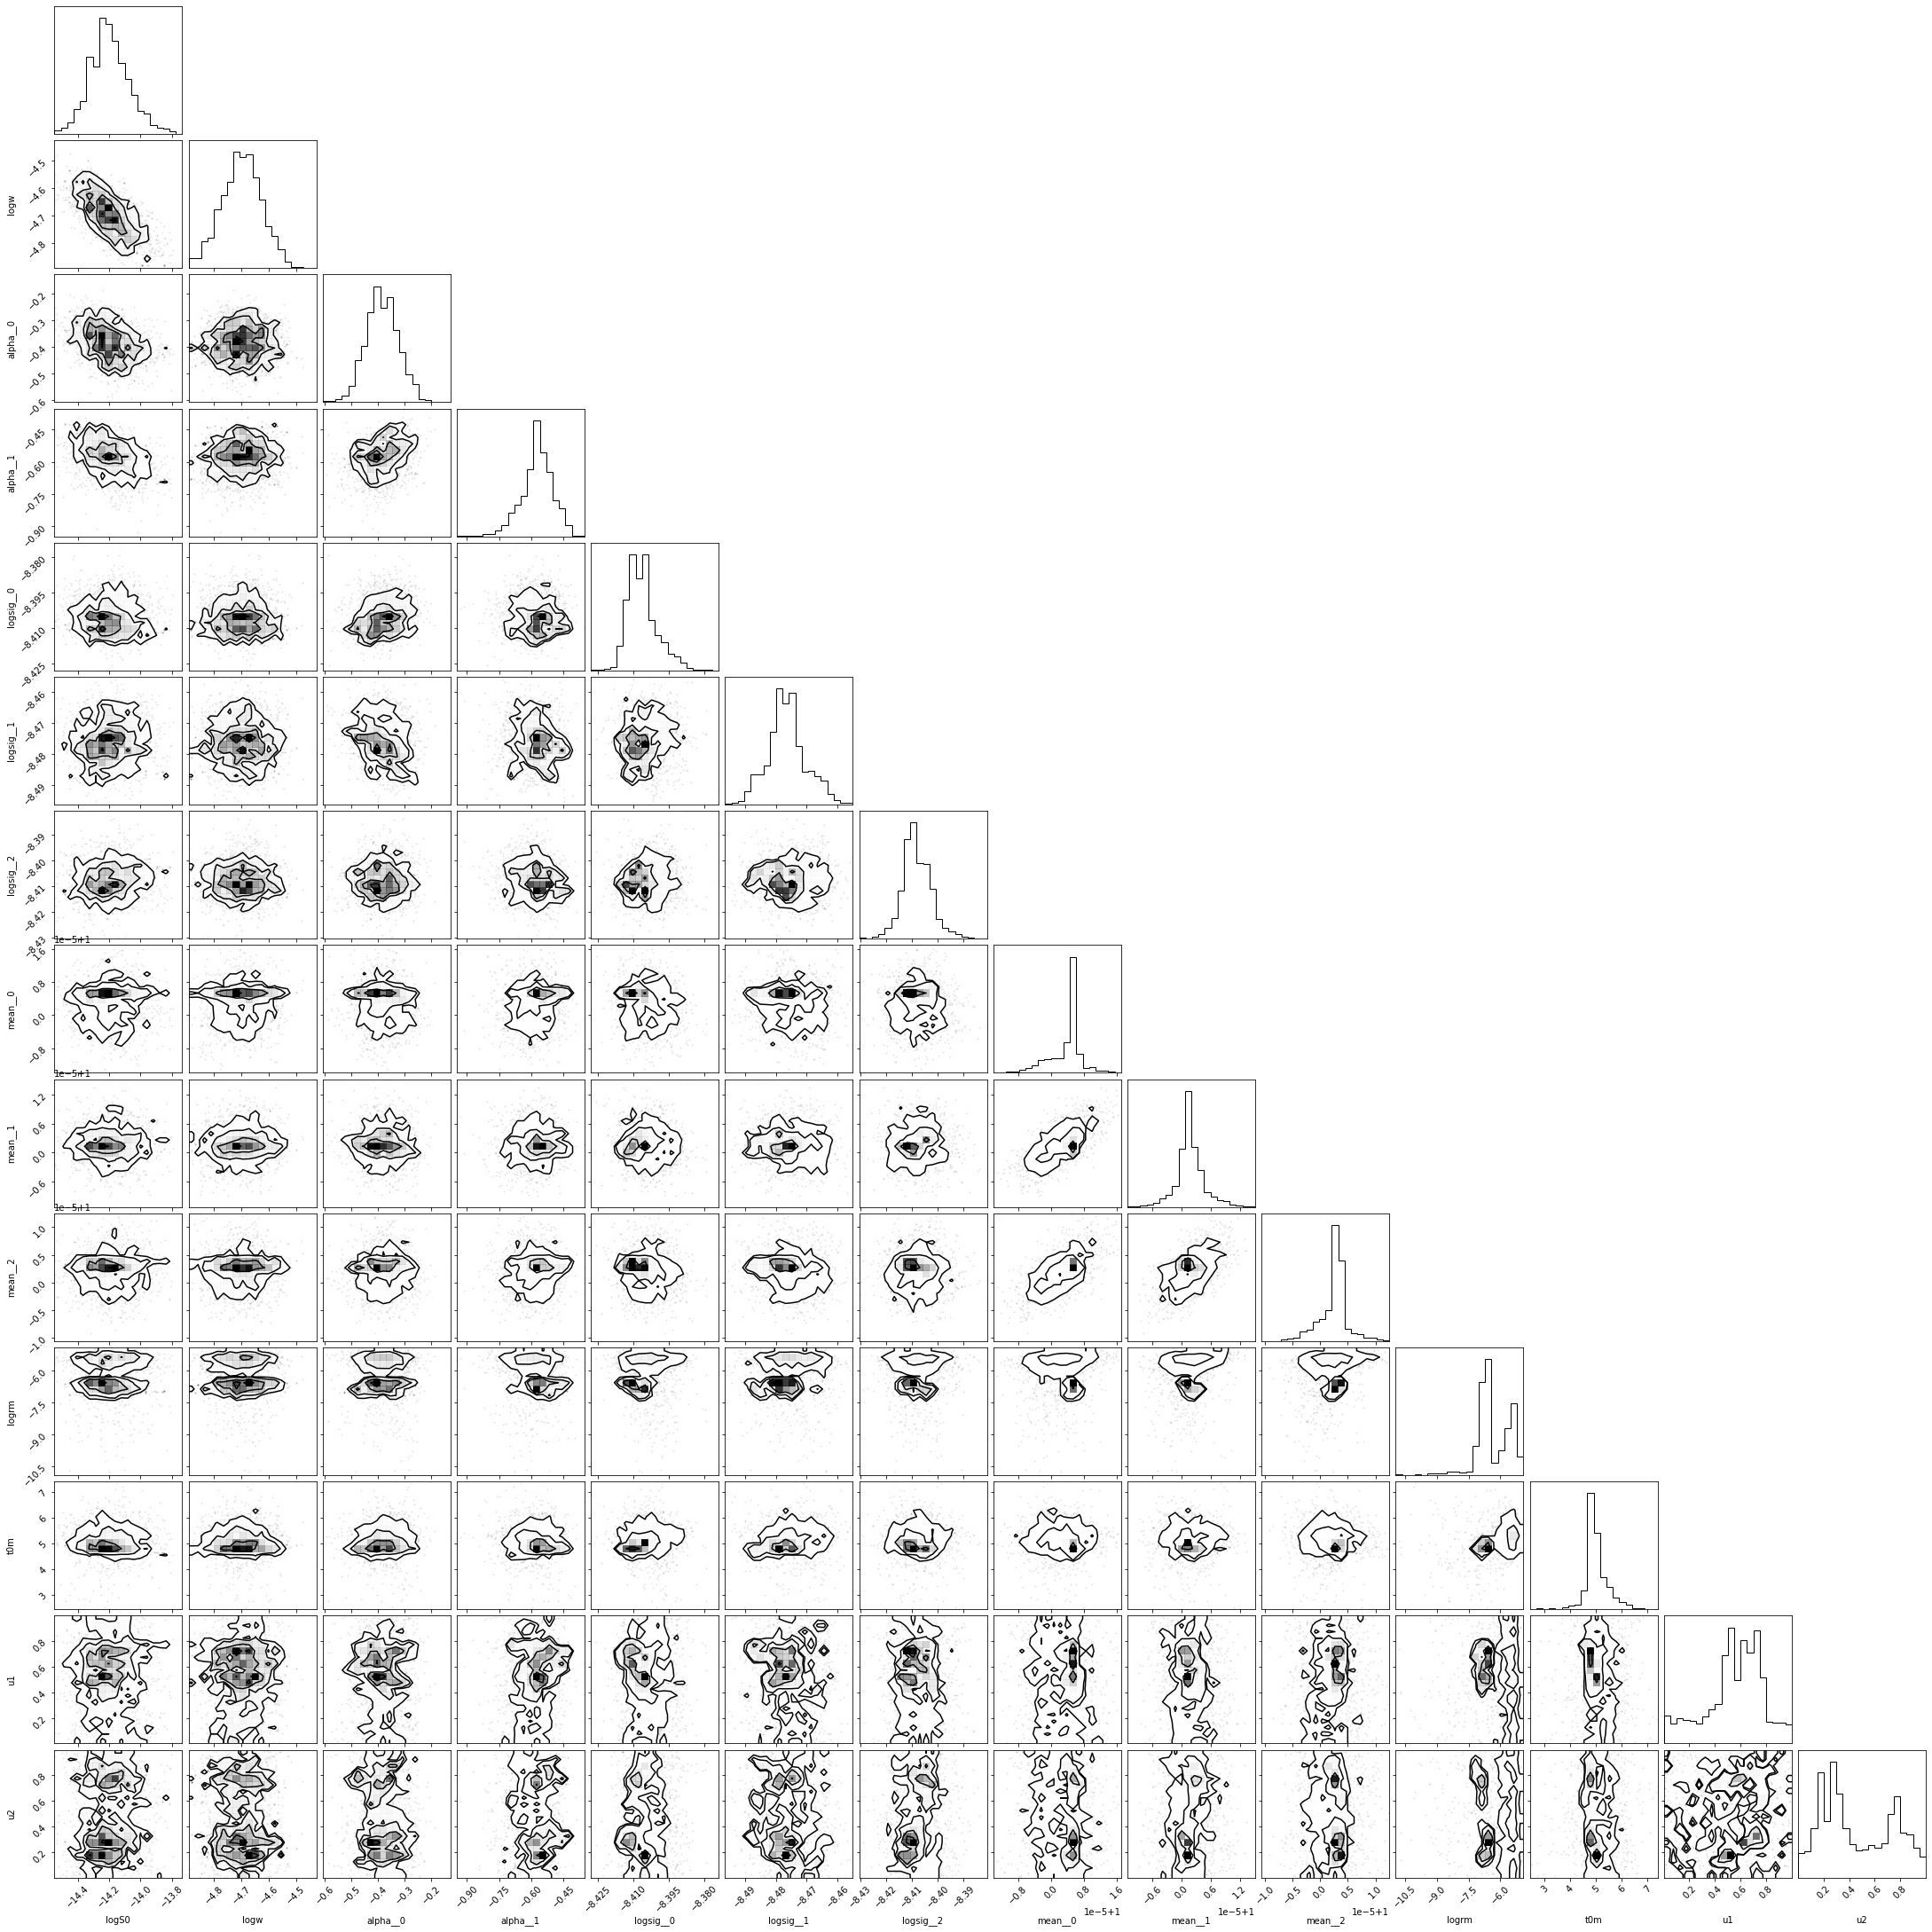

In [756]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

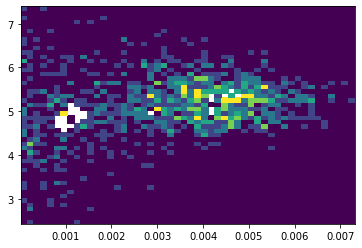

In [765]:
pl.hist2d(np.exp(trace['logrm']), trace['t0m'], bins=50, cmax=5);

In [772]:
with model:
    newtrace = pm.sample(
        tune=2000,
        draws=2000,
        start=trace[-1],
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]
INFO:pymc3:NUTS: [t0m, logrm, u2, u1, mean, logsig, alpha, logw, logS0]


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16359 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16359 seconds.


['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']
['/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/include', '/usr/local/lib/python3.8/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


(array([162.64612708, 131.76395105, 104.31312792,  92.64652808,
        109.80329254, 111.1758337 , 159.21477419, 144.11682147,
        187.3518679 , 209.99879699, 248.42994938, 229.21437319,
        294.41007814, 202.44982063, 156.46969188, 110.48956312,
         56.96045801,  23.33319967,   8.23524694,   2.05881174]),
 array([1.59374068e-05, 3.80225208e-04, 7.44513009e-04, 1.10880081e-03,
        1.47308861e-03, 1.83737641e-03, 2.20166421e-03, 2.56595201e-03,
        2.93023982e-03, 3.29452762e-03, 3.65881542e-03, 4.02310322e-03,
        4.38739102e-03, 4.75167882e-03, 5.11596662e-03, 5.48025442e-03,
        5.84454223e-03, 6.20883003e-03, 6.57311783e-03, 6.93740563e-03,
        7.30169343e-03]),
 <BarContainer object of 20 artists>)

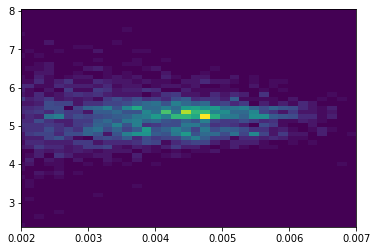

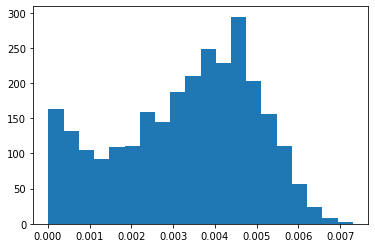

In [795]:
pl.hist2d(np.exp(newtrace['logrm']), newtrace['t0m'], bins=50);
pl.xlim(0.002, 0.007)
pl.figure()
pl.hist(np.exp(newtrace['logrm']), bins=20, density=True)

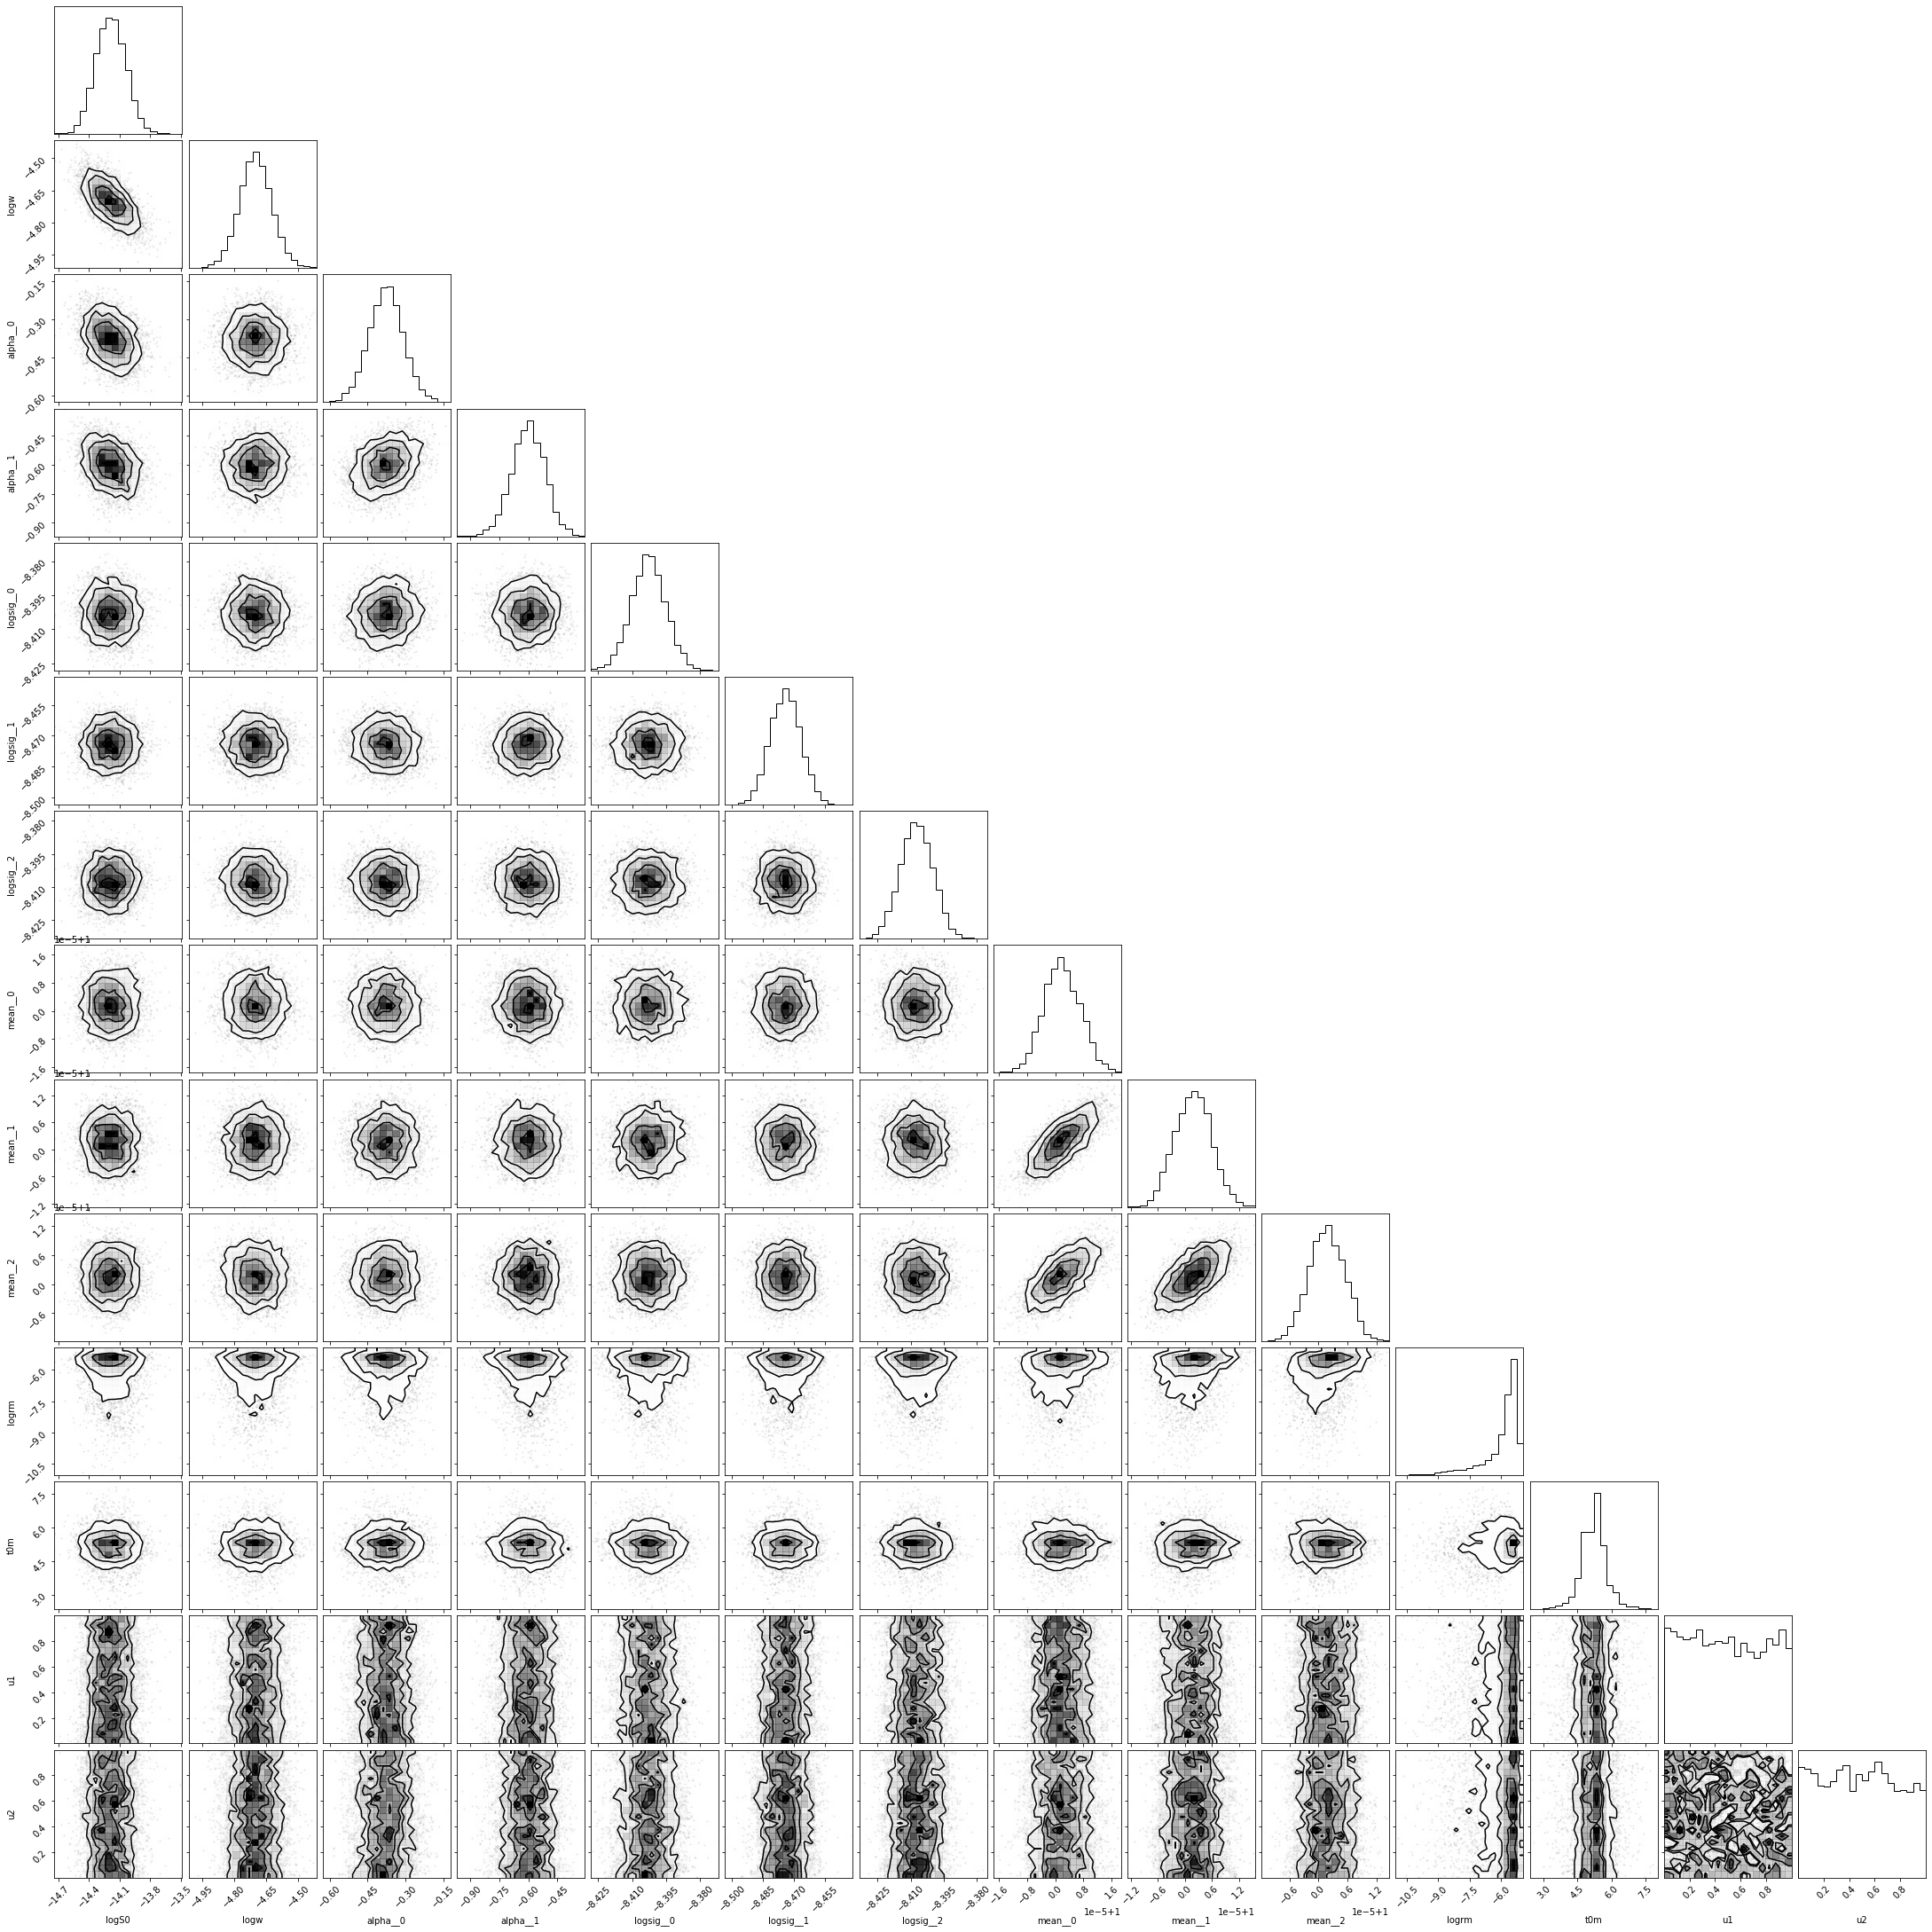

In [791]:
import corner
samples = pm.trace_to_dataframe(newtrace)
_ = corner.corner(samples)

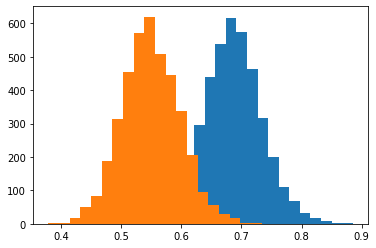

In [789]:
pl.hist(np.exp(newtrace['alpha'][:,0]), bins=20);
pl.hist(np.exp(newtrace['alpha'][:,1]), bins=20);